In [51]:
import numpy as np
import matplotlib.pyplot as plt     
import pandas as pd                 # optional
import seaborn as sns               # optional

%matplotlib inline

**FASTA Sequence Files:**
- PapayaSalad: 38411 bp Streptomyces phage
- OscarSo: 33432 bp Microbacterium phage

**Pure datasets of sequencing reads from each phage type:**
- strep-test.fa: 10,000 reads of length 200 from the Streptomyces phage type (FASTA format)
- micro-test.fa: 10,000 reads of length 200 from the Microbacterium phage type (FASTA format)

**Question 1:** Test Moriarty's method yourself.

In [52]:
# function to convert FASTA file to a list of sequences
def converter(file_name):

    # read and open the file
    with open(file_name, 'r') as file:
        sequences = []
        sequence = ''  

        for line in file:
            # if the line starts with '>', it's a new sequence header
            if line.startswith('>'):
                # if there's already a sequence, append it to sequences list
                if sequence:
                    sequences.append(sequence)
                    sequence = ''  # reset for the next sequence

            # strip whitespace/linebreaks and add the line to the current sequence
            else:
                sequence += line.strip()

        # append the last sequence after the loop ends
        if sequence:
            sequences.append(sequence)
    
    # return the list of sequences
    return sequences

Our goal is to replicate a histogram and a ROC plot like in Moriarty's figure, but for performance in discriminating Microbacterium phage reads from Streptomyces phage reads. Below, we convert the FASTA files into text and implement Moriarty's scoring method (score +1 for each C or G, and -1 for each A or T).

In [53]:
# convert FASTA files
strep_test = converter('strep-test.fa')
micro_test = converter('micro-test.fa')
random_test = converter('moriarty-neg.fa')

In [54]:
# moriarty's scoring method: score +1 for each C or G, and -1 for each A or T
def moriarty_score(sequence):
    AT_score = 0
    GC_score = 0
    for base in sequence:
        if base == 'A' or base == 'T':
            AT_score += 1
        elif base == 'G' or base =='C':
            GC_score +=1
    score = GC_score - AT_score
    return score

Below, I run Moriarty's scoring method on all 10000 sequences for the Streptomyces phage type and the the Microbacterium phage type and store the scores in the lists <code>strep_scores</code> and <code>micro_scores</code>.

In [55]:
# score Strep phage type
strep_scores = []
for read in strep_test:
    score = moriarty_score(read)
    strep_scores.append(score)

In [56]:
# score Micro phage type
micro_scores = []
for read in micro_test:
    score = moriarty_score(read)
    micro_scores.append(score)

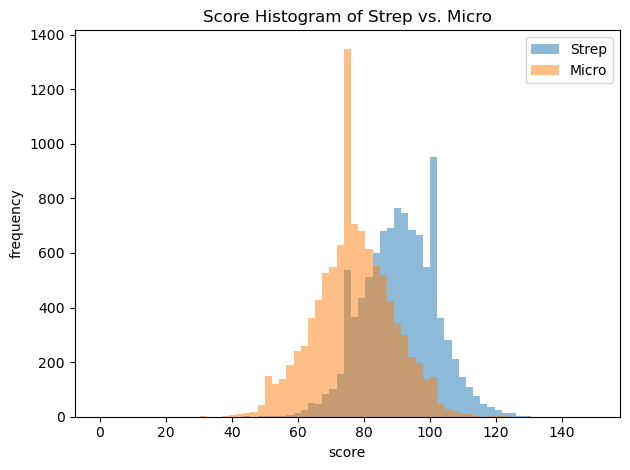

In [57]:
# overlapping histogram of the scores 
bins = np.linspace(0, 150, 70)

plt.hist(strep_scores, bins = bins, alpha=0.5, label='Strep')
plt.hist(micro_scores, bins = bins, alpha=0.5, label='Micro')
plt.legend(loc='upper right')
plt.xlabel('score')
plt.ylabel('frequency')
plt.title('Score Histogram of Strep vs. Micro')

plt.tight_layout()
plt.show()

**Interpretation:** We can see that there is a lot of overlap between the Strep and Micro phages. The fact that Moriarty's scoring method leads to a significant overlap allows us to conclude that it might not be a good discrimination method; this overlap is likely due to the fact that I am comparing two phage genomes, while Moriarty is comparing the Strep phage with negative (uniformly random) controls. DNA in nature typically does not have a uniformly distributed base composition, hence why Moriarty's method does not work as well on the Strep and Micro phages. Phages also have a higher GC content compared to negative controls, which further explains why Moriarty's model does not discriminate the two phage genomes well. 

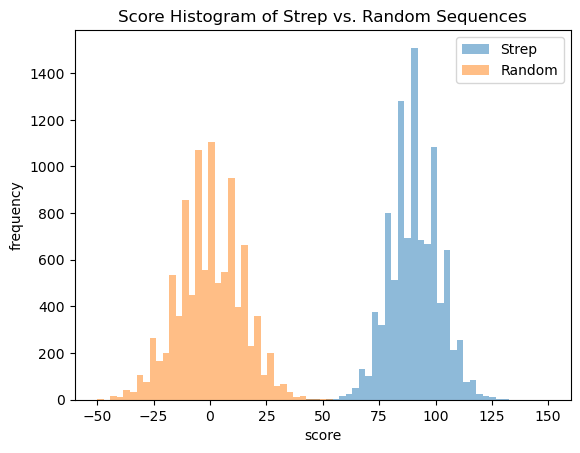

In [58]:
# recreate Moriarty's histogram (using the random sequences)
random_scores = []
for read in random_test:
    score = moriarty_score(read)
    random_scores.append(score)

# overlapping histogram of the scores 
bins = np.linspace(-50, 150, 70)

plt.hist(strep_scores, bins = bins, alpha=0.5, label='Strep')
plt.hist(random_scores, bins = bins, alpha=0.5, label='Random')
plt.legend(loc='upper right')
plt.xlabel('score')
plt.ylabel('frequency')
plt.title('Score Histogram of Strep vs. Random Sequences')

plt.show()

**Interpretation:** Once again, after plotting the histogram of Strep vs. random scores, we see that the distributions are separate, and Moriarty's scoring method only seems to work for distinguishing the Strep reads from the random ones. 

/var/folders/7s/gjcj1svx0_ngcpk6nl7gcf0c0000gn/T/ipykernel_12450/4165902919.py:27: RuntimeWarning: invalid value encountered in divide
  ax.plot(1-TN/(TN+FP), TP/(TP+FN), label='ROC Curve');


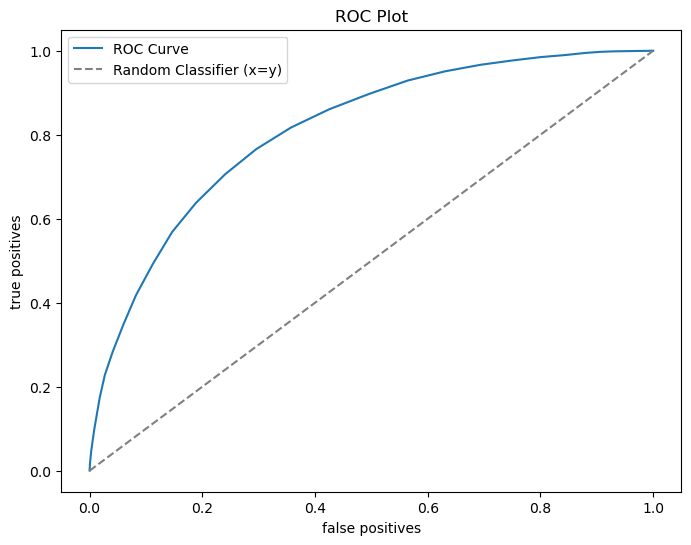

In [59]:
# ROC plot: true positives vs. false positives (TPR vs. FPR)

# find minimum and maximum scores across both genomes
min_score = np.min((strep_scores, micro_scores))
max_score = np.max((strep_scores, micro_scores))

# define number and range of threshold scores
num_thresh = 1000
threshold_scores = np.linspace(min_score, max_score, 150)

# true positive rate = true positives / (true positives + false negatives)
# false positive rate = false positives / (false positives + true negatives)
TP = np.zeros(num_thresh)
FP = np.zeros(num_thresh)
TN = np.zeros(num_thresh)
FN = np.zeros(num_thresh)

# calculate TP/FN/TN/FP for each sequence in both datasets
for i, score in enumerate(threshold_scores):
    TP[i] = np.sum(strep_scores>=score)
    FP[i] = np.sum(micro_scores>=score)
    TN[i] = np.sum(micro_scores<score)
    FN[i] = np.sum(strep_scores<score)
    
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(1-TN/(TN+FP), TP/(TP+FN), label='ROC Curve');
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier (x=y)") # plot random classifier
ax.set_title('ROC Plot')
ax.set_xlabel('false positives');
ax.set_ylabel('true positives');
plt.legend()
plt.show()

**Interpretation:** The ROC plot shows that Moriarty's model performs better than just a random classifier (which would be a diagonal line); however, it still shows that as the proportion of true positives increases, so do the proportion of false positives. 

**Question 2:** Make your own method - implement a second order Markov model.

Find the frequency of distinct two-mers and three-mers (as combinations of the four nucleotide bases) and read in/convert our training data.

In [60]:
# find all distinct 2-mer and 3-mer sequences and store them in lists
import itertools
from itertools import product

nts = ['A','G', 'C', 'T']

twomers = [''.join(i) for i in itertools.product(nts, repeat = 2)]
threemers = [''.join(i) for i in itertools.product(nts, repeat = 3)]

In [61]:
# prepare our training data
papaya = converter('papayasalad.fa')
oscar = converter('OscarSo.fa')

Below, we train our two models on the papayasalad and OscarSo genome, respectively. We do this by counting the occurrences (frequencies) of the twomers and threemers that occur in the training datasets, and then using this to calculate average probabilities of each sub-sequence showing up in the sequence. This is then used in the final calculationss (performed on the testing data sets)to represent initial probabilities. 

In [62]:
# Initialize counts array of 2-mers and 3-mers
twomer_counts_papaya = np.zeros(len(twomers))
twomer_counts_oscar = np.zeros(len(twomers))
threemer_counts_papaya = np.zeros(len(threemers))
threemer_counts_oscar = np.zeros(len(threemers))

# go through each sequence and identify 2-mers and 3-mers and update counts
# train two models: one on the papayasalad genome, and one on the OscarSo
for seq in papaya:
    for i, note in enumerate(seq):
        if i<len(seq)-1:
            idx = twomers.index(seq[i:i+2])
            twomer_counts_papaya[idx]+=1
            if i<len(seq)-2:
                idx = threemers.index(seq[i:i+3])
                threemer_counts_papaya[idx]+=1
                
for seq in oscar:
    for i, note in enumerate(seq):
        if i<len(seq)-1:
            idx = twomers.index(seq[i:i+2])
            twomer_counts_oscar[idx]+=1
            if i<len(seq)-2:
                idx = threemers.index(seq[i:i+3])
                threemer_counts_oscar[idx]+=1

In [63]:
# normalize counts to get frequencies/probabilities
threemer_prob_oscar = threemer_counts_oscar/np.sum(threemer_counts_oscar)
threemer_prob_papaya = threemer_counts_papaya/np.sum(threemer_counts_papaya)
twomer_prob_oscar = twomer_counts_oscar/np.sum(twomer_counts_oscar)
twomer_prob_papaya = twomer_counts_papaya/np.sum(twomer_counts_papaya)

I then implemented the second order Markov method utilizing the models trained on the papayasald and OscarSo genome. 

In [64]:
# initialize score array
strep_new_scores = np.zeros(len(strep_test))
micro_new_scores = np.zeros(len(micro_test))

# iterate through each test sequence (Strep and Micro)
for j, seq in enumerate(strep_test):
    # For each sequence, calculate the initial (joint) probability 
    # of the first two nucleotides under both models
    idx = twomers.index(seq[:2])
    strep_prob = np.log(threemer_prob_papaya[idx])
    micro_prob = np.log(threemer_prob_oscar[idx])
    
    # For each sequence, calculate the probabilities of each nucleotide given
    # the previous two nucleotides (starting with the third note) under both models
    for i, note in enumerate(seq[2:]):
        # i will start at 0
        threemer_idx = threemers.index(seq[i:i+3])
        twomer_idx = twomers.index(seq[i:i+2])
        strep_prob+= np.log(threemer_prob_papaya[threemer_idx])-np.log(twomer_prob_papaya[twomer_idx])
        micro_prob+=np.log(threemer_prob_oscar[threemer_idx])-np.log(twomer_prob_oscar[twomer_idx])
        
    # for each sequence, calculate a log-odds score and store it
    strep_new_scores[j] = strep_prob-micro_prob
    
for j, seq in enumerate(micro_test):
    # for each sequence, calculate the initial (joint) probability 
    # of the first two nucleotides under both models
    idx = twomers.index(seq[:2])
    strep_prob = np.log(threemer_prob_papaya[idx])
    micro_prob = np.log(threemer_prob_oscar[idx])
    
    # for each sequence, calculate the probabilities of each nucleotide given
    # the previous two nucleotides (starting with the third note) under both models
    for i, note in enumerate(seq[2:]):
        threemer_idx = threemers.index(seq[i:i+3])
        twomer_idx = twomers.index(seq[i:i+2])
        strep_prob+= np.log(threemer_prob_papaya[threemer_idx])-np.log(twomer_prob_papaya[twomer_idx])
        micro_prob+=np.log(threemer_prob_oscar[threemer_idx])-np.log(twomer_prob_oscar[twomer_idx])
        
    # for each sequence, calculate a log-odds score and store it
    micro_new_scores[j] = strep_prob-micro_prob

Below, I plot a histogram in order to visually view the distributions and overlap between the scores of the two phage genomes.

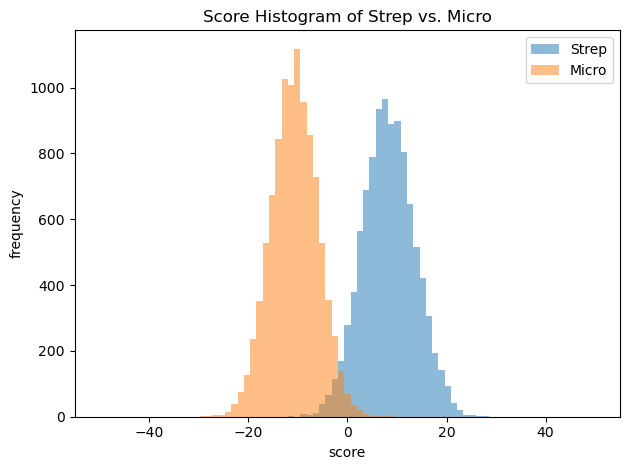

In [65]:
# overlapping histogram of the scores for our second order Markov model
bins = np.linspace(-50, 50, 80)

plt.hist(strep_new_scores, bins = bins, alpha=0.5, label='Strep')
plt.hist(micro_new_scores, bins = bins, alpha=0.5, label='Micro')
plt.legend(loc='upper right')
plt.xlabel('score')
plt.ylabel('frequency')
plt.title('Score Histogram of Strep vs. Micro')

plt.tight_layout()
plt.show()

**Interpretation:** As we can observe from our histogram of the Strep vs. Micro scores, there is much less overlap between the Strep and Micro scores as compared to the histogram plotted in question 1. Therefore, we can conclude that our second-order Markov model does a better job than Moriarty's model at discriminating between the two genomes.

/var/folders/7s/gjcj1svx0_ngcpk6nl7gcf0c0000gn/T/ipykernel_12450/3335824144.py:31: RuntimeWarning: invalid value encountered in divide
  ax.plot(1-TN/(TN+FP), TP/(TP+FN), label='ROC curve');


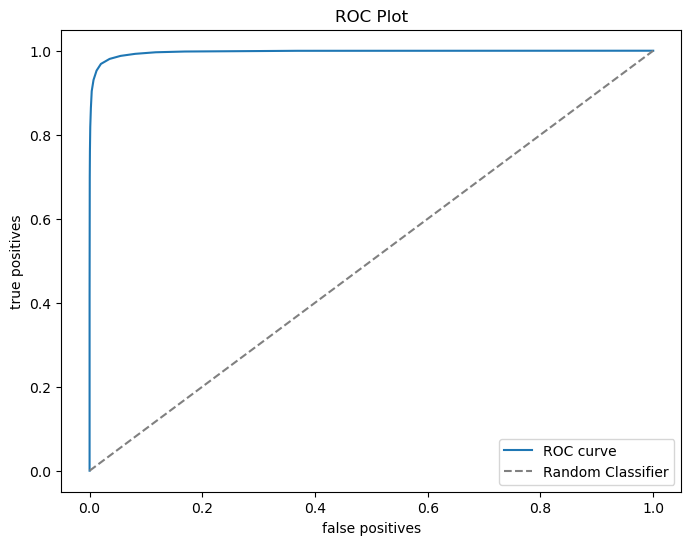

In [66]:
# ROC plot: true positives vs. false positives (TPR vs. FPR)

# find minimum and maximum scores across both genomes
min_score = np.min((strep_new_scores, micro_new_scores))
max_score = np.max((strep_new_scores, micro_new_scores))

# define number and range of threshold scores
num_thresh = 1000
new_threshold_scores = np.linspace(min_score, max_score, 60)

# true positive rate = true positives / (true positives + false negatives)
# false positive rate = false positives / (false positives + true negatives)
TP = np.zeros(num_thresh)
FP = np.zeros(num_thresh)
TN = np.zeros(num_thresh)
FN = np.zeros(num_thresh)

# calculate TP/FN/TN/FP for each sequence in both datasets
for i, score in enumerate(new_threshold_scores):
    TP[i] = np.sum(strep_new_scores>=score)
    FP[i] = np.sum(micro_new_scores>=score)
    TN[i] = np.sum(micro_new_scores<score)
    FN[i] = np.sum(strep_new_scores<score)
    
fig, ax = plt.subplots(figsize=(8,6))

# for plotting a random classifier
x = np.linspace(0, 1, 100)
y = x

ax.plot(1-TN/(TN+FP), TP/(TP+FN), label='ROC curve');
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
ax.set_title('ROC Plot')
ax.set_xlabel('false positives');
ax.set_ylabel('true positives');
plt.legend()
plt.show()

**Interpretation:** Based on the ROC plot above, we can further conclude that our model is outperforming Moriarty's model. The ROC curve is closer to the upper left of the graph, or in general indicative that more true positives are being detected and less false positives are detected out of the total positive rate. 

In [67]:
total_length = 10000 * 200

def GC_comp(genome):
    GC_count = 0
    for seq in genome:
        for i in seq:
            if i == 'G' or i == 'C':
                GC_count += 1
    return GC_count / total_length

In [68]:
print('GC Composition of the Micro genome:', GC_comp(micro_test))
print('GC Composition of the Strep genome:', GC_comp(strep_test))

GC Composition of the Micro genome: 0.691857
GC Composition of the Strep genome: 0.727093


Above, we confirm that the GC Composition is higher than normal for both of these phage genomes, which is likely leading to the difficulty in detection using a model that gives uniform weight to all bases (such as Moriarty's model).

**Question 3:** How good is your method?

In [69]:
# the lab wants to achieve 90% sensitivity for detecting Microbacterium phage reads
x= sorted(strep_new_scores.tolist())
idx = 1000
threshold = x[idx]

# identify the threshold using this given 90% sensitivity goal
print(f"Score Threshold for Sensitivity of 90%: " + str(round(threshold, 4)))

Score Threshold for Sensitivity of 90%: 1.7215


In [70]:
# calculate the counts for true positives, false positives, true negatives, and false negatives
TP = np.sum(strep_new_scores>=threshold)

# in particular, we count how many scores in the microbacterium array are greater than this threshold of 1.7215
# this is our number of false positives (falsely detected positives)
FP = np.sum(micro_new_scores>=threshold)
TN = np.sum(micro_new_scores<threshold)
FN = np.sum(strep_new_scores<threshold)

In [71]:
# calculate false positive rate
fpr = FP/(FP+TN)
print('False Positive Rate:', fpr)

False Positive Rate: 0.0036


Suppose the lab wants to achieve 90% sensitivity for detecting Microbacterium phage reads.
- What score threshold would you need to set?

**Answer:** In order to calculate the score threshold we would need to set to achieve a 90% sensitivity for detecting Microbacterium phage reads, we can iterate through the list of sensitivity scores at the different threshold values (in <code>threshold_scores</code>). We have identified that a threshold of 1.7 for our scores. 
  
- What is your estimate for the false positive rate at that threshold?

**Answer:** Our estimate for the false positive rate is 0.0036, or 0.36%. At first, this implies that our model is performing very well, since it seems that not many false positives are being detected.

In [72]:
FDR = (FP*0.999)/(TP*0.001+FP*0.999)
print('If 0.1% of population is special, FDR is', round(FDR,4))

If 0.1% of population is special, FDR is 0.7998


**Interpretation:** From our analysis, we see that we have quite a high false discovery rate (0.7998, or around 80%) despite high sensitivity and specificity; this is likely due to the fact that we still have a high number of negatives being detected. We can conclude that this method is adequate for discriminating between the genomes, but a different method could likely be better (due to the high FDR). 

Despite having a low FPR at the given threshold that we have chosen, we have a high FDR because we are going to be discovering a "rare thing" incorrectly. 80% of the predictions will be false. Our population is so biased because of how our population is split. 

In [73]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyter

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyter   : 1.1.1

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

